In [1]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-0oimk5g1
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-0oimk5g1
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit fcd09fe8b6bf57643bde7847bf42a6719b7ee205
  Installing build dependencies ..done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.



I risultati verranno salvati in: 'chronos_results_final_20250912_142125'
--- Inizio Script di Valutazione Chronos ---
Dispositivo utilizzato: cuda

Dati caricati con successo. Numero di punti: 324
Modello Chronos amazon/chronos-t5-small caricato.

--- FOLD 1/5 ---
  Lunghezza training: 264, Lunghezza test: 12
  Previsione di 12 step futuri...
  RMSE Fold 1: 13660.8937
  MSE Fold 1: 186620016.0000
  MAE Fold 1: 13161.5654
--- FOLD 2/5 ---
  Lunghezza training: 276, Lunghezza test: 12
  Previsione di 12 step futuri...
  RMSE Fold 2: 23551.5122
  MSE Fold 2: 554673728.0000
  MAE Fold 2: 22089.1074
--- FOLD 3/5 ---
  Lunghezza training: 288, Lunghezza test: 12
  Previsione di 12 step futuri...
  RMSE Fold 3: 32935.3558
  MSE Fold 3: 1084737664.0000
  MAE Fold 3: 31055.2969
--- FOLD 4/5 ---
  Lunghezza training: 300, Lunghezza test: 12
  Previsione di 12 step futuri...
  RMSE Fold 4: 40519.9187
  MSE Fold 4: 1641863808.0000
  MAE Fold 4: 35983.8594
--- FOLD 5/5 ---
  Lunghezza training: 31

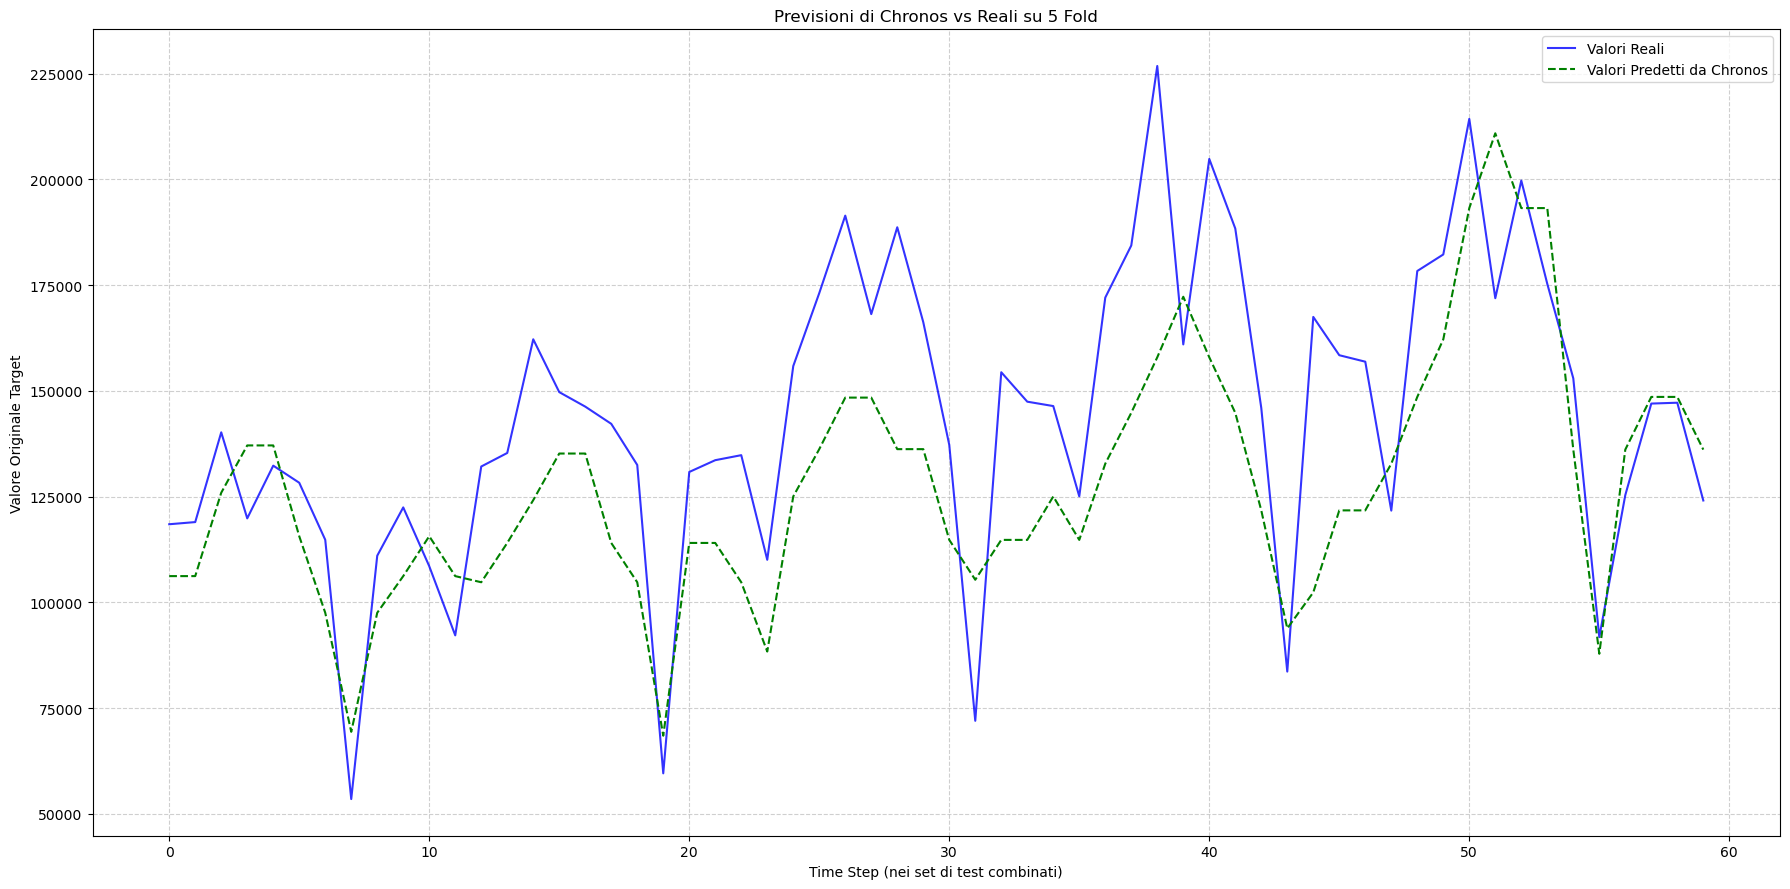


--- Analisi degli Errori ---


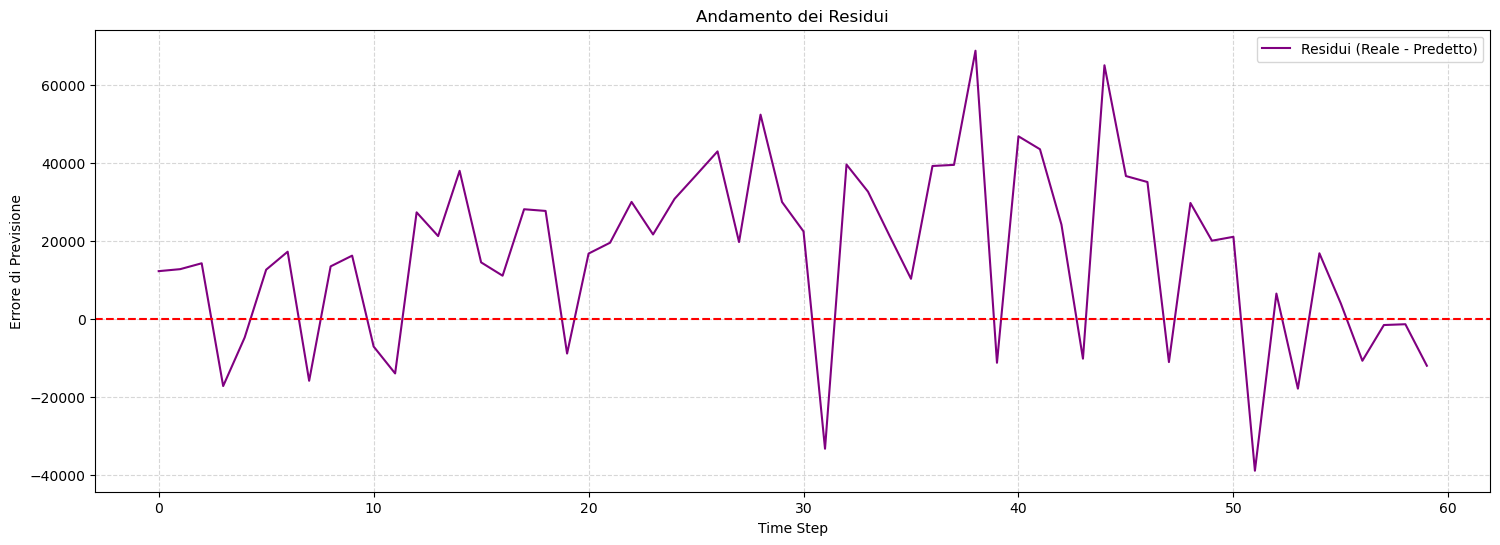

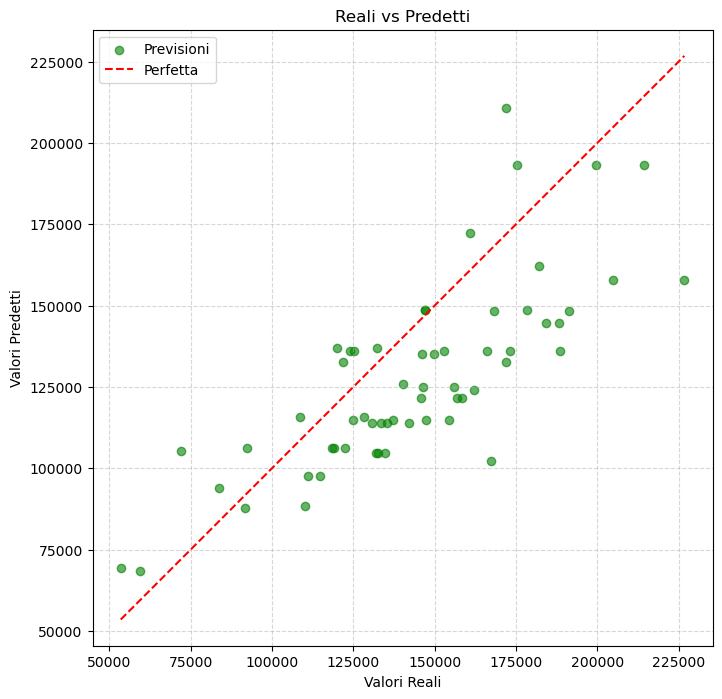

  Errore relativo medio: 16.12%

✅ Script completato. Risultati salvati in: 'chronos_results_final_20250912_142125'


In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from chronos import ChronosPipeline

# --------------------------------------------------------------------------
# 1. CONFIGURAZIONE
# --------------------------------------------------------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FILE_PATH = "testDati.csv"
TARGET_COL_INDEX = 8
SEQ_LENGTH = 24
N_SPLITS = 5
TEST_SIZE = 12

# cartella risultati
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RESULTS_DIR = f"chronos_results_final_{timestamp}"
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"\nI risultati verranno salvati in: '{RESULTS_DIR}'")

print(f"--- Inizio Script di Valutazione Chronos ---")
print(f"Dispositivo utilizzato: {DEVICE}\n")

# --------------------------------------------------------------------------
# 2. CARICAMENTO E PREPROCESSING DEI DATI
# --------------------------------------------------------------------------
try:
    data_df = pd.read_csv(FILE_PATH, header=None, usecols=[TARGET_COL_INDEX])
    target_series = data_df[TARGET_COL_INDEX].astype(np.float32).values
    shift_start = 24 
    target_series = target_series[shift_start:]
    target_series_log = np.log1p(target_series)
    print(f"Dati caricati con successo. Numero di punti: {len(target_series_log)}")
except FileNotFoundError:
    print(f"ERRORE: File '{FILE_PATH}' non trovato.")
    exit()
except Exception as e:
    print(f"ERRORE durante la lettura del file: {e}")
    exit()

# --------------------------------------------------------------------------
# 3. CARICAMENTO DEL MODELLO CHRONOS
# --------------------------------------------------------------------------
model = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map=DEVICE,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
)
print(f"Modello Chronos amazon/chronos-t5-small caricato.\n")

# --------------------------------------------------------------------------
# 4. CROSS-VALIDATION
# --------------------------------------------------------------------------
tscv = TimeSeriesSplit(n_splits=N_SPLITS, test_size=TEST_SIZE)
all_y_test, all_y_pred = [], []

metrics_per_fold = []

for fold, (train_index, test_index) in enumerate(tscv.split(target_series_log)):
    print(f"--- FOLD {fold + 1}/{N_SPLITS} ---")

    train_data = target_series_log[train_index]
    test_data = target_series_log[test_index]

    prediction_horizon = TEST_SIZE

    if len(train_data) < SEQ_LENGTH + prediction_horizon:
        print(f"  Fold {fold + 1} saltato: training troppo corto.")
        continue

    context = train_data[-SEQ_LENGTH:]

    print(f"  Lunghezza training: {len(train_data)}, Lunghezza test: {len(test_data)}")
    print(f"  Previsione di {prediction_horizon} step futuri...")

    with torch.no_grad():
        outputs = model.predict(
            torch.tensor(context),
            prediction_horizon,
            num_samples=20,
        )
        prediction_scaled = outputs.median(dim=1).values.squeeze(0).cpu().numpy()

    y_pred_final = np.expm1(prediction_scaled)
    y_test_final = np.expm1(test_data)

    all_y_pred.extend(y_pred_final)
    all_y_test.extend(y_test_final)

    rmse_fold = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
    mse_fold = mean_squared_error(y_test_final, y_pred_final)
    mae_fold = mean_absolute_error(y_test_final, y_pred_final)
    print(f"  RMSE Fold {fold + 1}: {rmse_fold:.4f}")
    print(f"  MSE Fold {fold + 1}: {mse_fold:.4f}")
    print(f"  MAE Fold {fold + 1}: {mae_fold:.4f}")

    # Salvataggio predizioni del fold
    fold_df = pd.DataFrame({
        'y_test': y_test_final,
        'y_pred': y_pred_final
    })
    fold_df.to_csv(os.path.join(RESULTS_DIR, f'fold_{fold+1}_predictions.csv'), index=False)

    metrics_per_fold.append({
        'fold': fold + 1,
        'rmse': rmse_fold,
        'mse': mse_fold,
        'mae': mae_fold
    })

# --------------------------------------------------------------------------
# 5. RISULTATI FINALI E VISUALIZZAZIONE
# --------------------------------------------------------------------------
y_true_combined = np.array(all_y_test)
y_pred_combined = np.array(all_y_pred)

final_rmse = np.sqrt(mean_squared_error(y_true_combined, y_pred_combined))
final_mae = mean_absolute_error(y_true_combined, y_pred_combined)
final_mse = mean_squared_error(y_true_combined, y_pred_combined)

summary_path = os.path.join(RESULTS_DIR, 'summary_metrics.txt')
with open(summary_path, 'w') as f:
    f.write("--- Risultati Finali Chronos ---\n")
    f.write(f"RMSE: {final_rmse:.4f}\n")
    f.write(f"MAE: {final_mae:.4f}\n")
    f.write(f"MSE: {final_mse:.4f}\n")

print("\n--- Risultati Finali ---")
print(f"  RMSE: {final_rmse:.4f}")
print(f"  MAE: {final_mae:.4f}")
print(f"  MSE: {final_mse:.4f}")

pd.DataFrame(metrics_per_fold).to_csv(os.path.join(RESULTS_DIR, 'fold_metrics.csv'), index=False)

# Plot 1: Previsioni vs Reali
plt.figure(figsize=(18, 9))
plt.plot(y_true_combined, label='Valori Reali', color='blue', alpha=0.8)
plt.plot(y_pred_combined, label='Valori Predetti da Chronos', color='green', linestyle='--')
plt.title(f"Previsioni di Chronos vs Reali su {N_SPLITS} Fold")
plt.xlabel("Time Step (nei set di test combinati)")
plt.ylabel("Valore Originale Target")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'predictions_vs_real.png'))
plt.show()

# --------------------------------------------------------------------------
# 6. ANALISI DEGLI ERRORI
# --------------------------------------------------------------------------
print("\n--- Analisi degli Errori ---")
residuals = y_true_combined - y_pred_combined

# Plot 2: Residui nel tempo
plt.figure(figsize=(18, 6))
plt.plot(residuals, label='Residui (Reale - Predetto)', color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title('Andamento dei Residui')
plt.xlabel('Time Step')
plt.ylabel('Errore di Previsione')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(os.path.join(RESULTS_DIR, 'residuals_plot.png'))
plt.show()

# Plot 3: Scatter Reali vs Predetti
plt.figure(figsize=(8, 8))
plt.scatter(y_true_combined, y_pred_combined, alpha=0.6, color='green', label='Previsioni')
perfect_line = np.linspace(min(y_true_combined), max(y_true_combined), 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Perfetta')
plt.title('Reali vs Predetti')
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.axis('equal')
plt.savefig(os.path.join(RESULTS_DIR, 'scatter_real_vs_pred.png'))
plt.show()

# Errore relativo medio
epsilon = 1e-9
relative_errors = np.abs(residuals) / np.maximum(y_true_combined, epsilon)
mean_rel_error = np.mean(relative_errors) * 100
print(f"  Errore relativo medio: {mean_rel_error:.2f}%")

# Salvataggio errore relativo
with open(summary_path, 'a') as f:
    f.write(f"Errore relativo medio: {mean_rel_error:.2f}%\n")

print(f"\n✅ Script completato. Risultati salvati in: '{RESULTS_DIR}'")
